In [1]:
# # https://github.com/crflynn/fbm - Christopher Flynn

# """Generate realizations of fractional Brownian motion."""
# import warnings

# import numpy as np


# class FBM(object):
#     """The FBM class.

#     After instantiating with n = number of increments, hurst parameter, length
#     of realization (default = 1) and method of generation
#     (default daviesharte), call fbm() for fBm, fgn()
#     for fGn, or times() to get corresponding time values.
#     """

#     def __init__(self, n, hurst, length=1, method="daviesharte"):
#         """Instantiate the FBM."""
#         self._methods = {"daviesharte": self._daviesharte, "cholesky": self._cholesky, "hosking": self._hosking}
#         self.n = n
#         self.hurst = hurst
#         self.length = length
#         self.method = method
#         self._fgn = self._methods[self.method]
#         # Some reusable values to speed up Monte Carlo.
#         self._cov = None
#         self._eigenvals = None
#         self._C = None
#         # Flag if some params get changed
#         self._changed = False

#     def __str__(self):
#         """Str method."""
#         return (
#             "fBm ("
#             + str(self.method)
#             + ") on [0, "
#             + str(self.length)
#             + "] with Hurst value "
#             + str(self.hurst)
#             + " and "
#             + str(self.n)
#             + " increments"
#         )

#     def __repr__(self):
#         """Repr method."""
#         return (
#             "FBM(n="
#             + str(self.n)
#             + ", hurst="
#             + str(self.hurst)
#             + ", length="
#             + str(self.length)
#             + ', method="'
#             + str(self.method)
#             + '")'
#         )

#     @property
#     def n(self):
#         """Get the number of increments."""
#         return self._n

#     @n.setter
#     def n(self, value):
#         if not isinstance(value, int) or value <= 0:
#             raise TypeError("Number of increments must be a positive int.")
#         self._n = value
#         self._changed = True

#     @property
#     def hurst(self):
#         """Hurst parameter."""
#         return self._hurst

#     @hurst.setter
#     def hurst(self, value):
#         if not isinstance(value, float) or value <= 0 or value >= 1:
#             raise ValueError("Hurst parameter must be in interval (0, 1).")
#         self._hurst = value
#         self._changed = True

#     @property
#     def length(self):
#         """Get the length of process."""
#         return self._length

#     @length.setter
#     def length(self, value):
#         if not isinstance(value, (int, float)) or value <= 0:
#             raise ValueError("Length of fbm must be greater than 0.")
#         self._length = value
#         self._changed = True

#     @property
#     def method(self):
#         """Get the algorithm used to generate."""
#         return self._method

#     @method.setter
#     def method(self, value):
#         if value not in self._methods:
#             raise ValueError("Method must be 'daviesharte', 'hosking' or 'cholesky'.")
#         self._method = value
#         self._fgn = self._methods[self.method]
#         self._changed = True

#     def fbm(self):
#         """Sample the fractional Brownian motion."""
#         return np.insert(self.fgn().cumsum(), [0], 0)

#     def fgn(self):
#         """Sample the fractional Gaussian noise."""
#         scale = (1.0 * self.length / self.n) ** self.hurst
#         gn = np.random.normal(0.0, 1.0, self.n)

#         # If hurst == 1/2 then just return Gaussian noise
#         if self.hurst == 0.5:
#             return gn * scale
#         else:
#             fgn = self._fgn(gn)

#         # Scale to interval [0, L]
#         return fgn * scale

#     def times(self):
#         """Get times associated with the fbm/fgn samples."""
#         return np.linspace(0, self.length, self.n + 1)

#     def _autocovariance(self, k):
#         """Autocovariance for fgn."""
#         return 0.5 * (abs(k - 1) ** (2 * self.hurst) - 2 * abs(k) ** (2 * self.hurst) + abs(k + 1) ** (2 * self.hurst))

#     def _daviesharte(self, gn):
#         """Generate a fgn realization using Davies-Harte method.

#         Uses Davies and Harte method (exact method) from:
#         Davies, Robert B., and D. S. Harte. "Tests for Hurst effect."
#         Biometrika 74, no. 1 (1987): 95-101.

#         Can fail if n is small and hurst close to 1. Falls back to Hosking
#         method in that case. See:

#         Wood, Andrew TA, and Grace Chan. "Simulation of stationary Gaussian
#         processes in [0, 1] d." Journal of computational and graphical
#         statistics 3, no. 4 (1994): 409-432.
#         """
#         # Monte carlo consideration
#         if self._eigenvals is None or self._changed:
#             # Generate the first row of the circulant matrix
#             row_component = [self._autocovariance(i) for i in range(1, self.n)]
#             reverse_component = list(reversed(row_component))
#             row = [self._autocovariance(0)] + row_component + [0] + reverse_component

#             # Get the eigenvalues of the circulant matrix
#             # Discard the imaginary part (should all be zero in theory so
#             # imaginary part will be very small)
#             self._eigenvals = np.fft.fft(row).real
#             self._changed = False

#         # If any of the eigenvalues are negative, then the circulant matrix
#         # is not positive definite, meaning we cannot use this method. This
#         # occurs for situations where n is low and H is close to 1.
#         # Fall back to using the Hosking method. See the following for a more
#         # detailed explanation:
#         #
#         # Wood, Andrew TA, and Grace Chan. "Simulation of stationary Gaussian
#         #     processes in [0, 1] d." Journal of computational and graphical
#         #     statistics 3, no. 4 (1994): 409-432.
#         if np.any([ev < 0 for ev in self._eigenvals]):
#             warnings.warn(
#                 "Combination of increments n and Hurst value H "
#                 "invalid for Davies-Harte method. Reverting to Hosking method."
#                 " Occurs when n is small and Hurst is close to 1. "
#             )
#             # Set method to hosking for future samples.
#             self.method = "hosking"
#             # Don"t need to store eigenvals anymore.
#             self._eigenvals = None
#             return self._hosking(gn)

#         # Generate second sequence of i.i.d. standard normals
#         gn2 = np.random.normal(0.0, 1.0, self.n)

#         # Resulting sequence from matrix multiplication of positive definite
#         # sqrt(C) matrix with fgn sample can be simulated in this way.
#         w = np.zeros(2 * self.n, dtype=complex)
#         for i in range(2 * self.n):
#             if i == 0:
#                 w[i] = np.sqrt(self._eigenvals[i] / (2 * self.n)) * gn[i]
#             elif i < self.n:
#                 w[i] = np.sqrt(self._eigenvals[i] / (4 * self.n)) * (gn[i] + 1j * gn2[i])
#             elif i == self.n:
#                 w[i] = np.sqrt(self._eigenvals[i] / (2 * self.n)) * gn2[0]
#             else:
#                 w[i] = np.sqrt(self._eigenvals[i] / (4 * self.n)) * (gn[2 * self.n - i] - 1j * gn2[2 * self.n - i])

#         # Resulting z is fft of sequence w. Discard small imaginary part (z
#         # should be real in theory).
#         z = np.fft.fft(w)
#         fgn = z[: self.n].real
#         return fgn

#     def _cholesky(self, gn):
#         """Generate a fgn realization using the Cholesky method.

#         Uses Cholesky decomposition method (exact method) from:
#         Asmussen, S. (1998). Stochastic simulation with a view towards
#         stochastic processes. University of Aarhus. Centre for Mathematical
#         Physics and Stochastics (MaPhySto)[MPS].
#         """
#         # Monte carlo consideration
#         if self._C is None or self._changed:
#             # Generate covariance matrix
#             G = np.zeros([self.n, self.n])
#             for i in range(self.n):
#                 for j in range(i + 1):
#                     G[i, j] = self._autocovariance(i - j)

#             # Cholesky decomposition
#             self._C = np.linalg.cholesky(G)
#             self._changed = False

#         # Generate fgn
#         fgn = np.dot(self._C, np.array(gn).transpose())
#         fgn = np.squeeze(fgn)
#         return fgn

#     def _hosking(self, gn):
#         """Generate a fGn realization using Hosking's method.

#         Method of generation is Hosking's method (exact method) from his paper:
#         Hosking, J. R. (1984). Modeling persistence in hydrological time series
#         using fractional differencing. Water resources research, 20(12),
#         1898-1908.
#         """
#         fgn = np.zeros(self.n)
#         phi = np.zeros(self.n)
#         psi = np.zeros(self.n)
#         # Monte carlo consideration
#         if self._cov is None or self._changed:
#             self._cov = np.array([self._autocovariance(i) for i in range(self.n)])
#             self._changed = False

#         # First increment from stationary distribution
#         fgn[0] = gn[0]
#         v = 1
#         phi[0] = 0

#         # Generate fgn realization with n increments of size 1
#         for i in range(1, self.n):
#             phi[i - 1] = self._cov[i]
#             for j in range(i - 1):
#                 psi[j] = phi[j]
#                 phi[i - 1] -= psi[j] * self._cov[i - j - 1]
#             phi[i - 1] /= v
#             for j in range(i - 1):
#                 phi[j] = psi[j] - phi[i - 1] * psi[i - j - 2]
#             v *= 1 - phi[i - 1] * phi[i - 1]
#             for j in range(i):
#                 fgn[i] += phi[j] * fgn[i - j - 1]
#             fgn[i] += np.sqrt(v) * gn[i]

#         return fgn


# def fbm(n, hurst, length=1, method="daviesharte"):
#     """One off sample of fBm."""
#     f = FBM(n, hurst, length, method)
#     return f.fbm()


# def fgn(n, hurst, length=1, method="daviesharte"):
#     """One off sample of fGn."""
#     f = FBM(n, hurst, length, method)
#     return f.fgn()


# def times(n, length=1):
#     """Generate the times associated with increments n and length."""
#     return np.linspace(0, length, n + 1)

In [2]:
# # General use
# # Estimate std scaling factor for h=[0.1,0.8] , n=1024

# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# data_std=[]
# h_arr= np.arange(0.1,0.8,0.05)
# for h in h_arr:
#     # generate some random data
#     data=[]
#     print('h =',h)
#     for j in range(1000):
#         f = FBM(1024, h)
#         fbm_sample = f.fbm()
#         data.append(fbm_sample[4]-fbm_sample[3])

#     # calc mean
#     meanval = np.mean(data)
#     print('mean =',meanval)

#     # calc standard deviation
#     data_cen = data - np.mean(data)
#     # or use numpy function
#     stdval = np.std(data,ddof=1) # note the second input to provide an unbiased estimate
#     print('std =',stdval)

#     # calc variance
#     varval1 = stdval**2
#     # or use numpy function
#     varval2 = np.var(data,ddof=1)
#     print('varval1 =',varval1)
#     print('varval2 =',varval2)

#     data_std.append(stdval)

# print('scale correction array h=',h_arr,'=> std_arr =',data_std)
# plt.plot(data_std)
# plt.plot(0.5**(h_arr*10))

# fBm - 1D

In [3]:
# import matplotlib.pyplot as plt

# x=[]
# y=[]

# for i in range(3):
#     h=0.25*(i+1)
#     f = FBM(n=1024, hurst=h, length=1, method='daviesharte')
#     x.append(f.times())
#     y.append(f.fbm())

# plt.subplot(3, 1, 1)
# plt.plot(x[0], y[0], '-')
# plt.title('1D fBm - H=0.25 ; H=0.5 ; H=0.75')
# plt.ylabel('H=0.25')

# plt.subplot(3, 1, 2)
# plt.plot(x[1], y[1],  '-')
# plt.xlabel('time (s)')
# plt.ylabel('H=0.5')

# plt.subplot(3, 1, 3)
# plt.plot(x[2], y[2],  '-')
# plt.xlabel('time (s)')
# plt.ylabel('H=0.75')

# plt.tight_layout()

# plt.show()


In [4]:
# # fBm simulation below is based on the davies-harte method 
# # Davies, Robert B., and D. S. Harte. "Tests for Hurst effect." Biometrika 74, no. 1 (1987): 95-101
# import warnings
# import numpy as np
# from fbm import FBM
# from fbm import fbm
# from fbm import times
# import matplotlib.pyplot as plt


# alpha_arr=np.array([1.67,0.8])

# h_arr=0.5*alpha_arr
# x=[]
# y=[]
# for h in h_arr:
#     f = FBM(n=1024, hurst=h, length=1, method='daviesharte')
#     scale=0.5**(h*10)
#     x.append(f.fbm()/scale)
#     y.append(f.fbm()/scale)


# fig_min,fig_max=-0.5,0.5
# plt.figure(figsize=(5,10))

# plt.subplot(2, 1, 1)
# plt.plot(x[0], y[0], '-')
# plt.title('2D fBm')
# plt.ylabel('alpha=1.67 ; H=0.835')
# # plt.xlim(fig_min,fig_max)
# # plt.ylim(fig_min,fig_max)

# plt.subplot(2, 1, 2)
# plt.plot(x[1], y[1], '-')
# plt.ylabel('alpha=0.8 ; H=0.4')
# # plt.xlim(fig_min,fig_max)
# # plt.ylim(fig_min,fig_max)

# plt.tight_layout()

# plt.show()


# MBM - Multifractional Brownian Motion

# 1D MBM
## alpha persistent = 1.67  , alpha antipersistent = 0.8
### A self-avoiding walk with neural delays as a model of fxational eye movements Carl J. J. Herrmann, Ralf Metzler & Ralf Engbert

In [5]:
# import inspect
# from math import gamma
# import numpy as np
# from mbm import MBM


# alpha_arr=np.array([1.67,0.8])
# trans_time=0.02 # the transition time from persistent to antipersistent motion

# h_arr=alpha_arr/2

# # Hurst function with respect to time.
# def h(t):
#     return h_arr[0]+(h_arr[1]-h_arr[0])*(np.tanh(t-trans_time)+1)/2

# m = MBM(n=1024, hurst=h, length=1, method='riemannliouville')

# t_values = m.times()
# x=m.mbm()

# plt.plot(t_values,x)
# plt.show()

# 2D MBM

## According to Engbert 2017, Nature:
## alpha persistent = 1.67  , alpha antipersistent = 0.8
## h = 0.835 , h = 0.4

In [6]:
# import inspect
# from math import gamma
# import numpy as np
# from mbm import MBM


# alpha_arr=np.array([1.67,0.8])
# trans_time=0.02 # the transition time from persistent to antipersistent motion

# h_arr=alpha_arr/2

# # Hurst function with respect to time.
# def h(t):
#     return h_arr[0]+(h_arr[1]-h_arr[0])*(np.tanh(t-trans_time)+1)/2

# m = MBM(n=1024, hurst=h, length=1, method='riemannliouville')

# # Get the times associated with the mBm
# t_values = m.times()

# x=[]
# y=[]
# for i in range(3):
#     x.append(m.mbm())
#     y.append(m.mbm())


# fig_min,fig_max=-0.5,0.5
# plt.figure(figsize=(5,10))

# plt.subplot(3, 1, 1)
# plt.plot(x[0], y[0], '-')
# plt.title('Traj 1')
# plt.ylabel('')

# plt.subplot(3, 1, 2)
# plt.plot(x[1], y[1], '-')
# plt.title('Traj 2')
# plt.ylabel('')

# plt.subplot(3, 1, 3)
# plt.plot(x[2], y[2], '-')
# plt.title('Traj 3')
# plt.ylabel('')

# plt.tight_layout()

# plt.show()


In [7]:
# # test time
# import time

# # fBm simulation below is based on the davies-harte method 
# # Davies, Robert B., and D. S. Harte. "Tests for Hurst effect." Biometrika 74, no. 1 (1987): 95-101
# import warnings
# import numpy as np
# from fbm import FBM
# from fbm import fbm
# from fbm import times
# import matplotlib.pyplot as plt

# # Function output - x,y coordinates [float] arrays of size n+1
# # h = alpha/2 ; Engbert 2017 alpha values were: alpha=1.67 for 20 ms persistent traj and alpha=0.8 for 100-400ms anti-persistent trajectory

# def ocdr_fbm(bm_steps=1024,h=0.5,ocdr_period_sec=0.5,n_samples=10,fov_len_pix=8,scale_sample_step=1):
#     f = FBM(n=bm_steps, hurst=h, length=ocdr_period_sec, method='daviesharte')
#     scale_std = (ocdr_period_sec/bm_steps)**h
#     scale_bm_step = n_samples/bm_steps
#     x,y = scale_sample_step*scale_bm_step*f.fbm()/scale_std, scale_sample_step*scale_bm_step*f.fbm()/scale_std # scale to normal gausian distribution of simulation step size
#     max_pos_dis_arr = np.ones(x.shape[0])*fov_len_pix/2
#     max_neg_dis_arr = -np.ones(x.shape[0])*fov_len_pix/2
#     x = np.minimum(x,max_pos_dis_arr)
#     x = np.maximum(x,max_neg_dis_arr)
#     y = np.minimum(y,max_pos_dis_arr)
#     y = np.maximum(y,max_neg_dis_arr)
#     sample_ind=np.arange(0,bm_steps,bm_steps//n_samples)
# #     return x,y # return the full trajectory n+1 points
#     return x[sample_ind],y[sample_ind] # returns sampled trajectory array of size (n_samples+1)

# # User input:
# h = 0.4 # set 0.1<h<0.9 ; brownian motion: h=0.5 ; persistent motion: h>0.5 ; anti-persistent motion: h<0.5
# bm_steps = 1024 # number of small brownian motion steps
# n_samples = 10 # number of samples from the brownian motion trajectory
# ocdr_period_sec=0.5 # ocular drift period [sec]
# fov_len_pix = 8 # fov_len_pix value corresponds with foveal pixl length and sets the motion max displacment to be +-(fov_len_pix/2)
# scale_sample_step = 1 # scales the brownian motion step size std


# print(t_end-t_start)

# data=[]
# for j in range(1000):
#     t_start=time.time()
#     # Generate 2D fractional brownian motion trajectory
#     x , y = ocdr_fbm(bm_steps,h,ocdr_period_sec,n_samples,max_dis_pix,scale_sample_step)
#     t_end=time.time()
#     data.append((t_end-t_start)*1000)

# # calc mean
# meanval = np.mean(data)
# print('mean =',meanval)

# # calc standard deviation
# data_cen = data - np.mean(data)
# # or use numpy function
# stdval = np.std(data,ddof=1) # note the second input to provide an unbiased estimate
# print('std =',stdval)

# # calc variance
# varval1 = stdval**2
# # or use numpy function
# varval2 = np.var(data,ddof=1)
# print('varval1 =',varval1)
# print('varval2 =',varval2)



# plt.plot(x,y)

# plt.show()


# ICLR Ocular drift simulation with fBm

# Load the FBM class - by Christopher Flynn

https://github.com/crflynn/fbm

MIT License

Copyright (c) 2017-2018 Christopher Flynn

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# fBm - 2D

# Sasha please use  h = 0.4 for the 0.5 sec ocular drift period

In [8]:
# Sasha - This the function that you use to produce random fractional brownian motion trajectories

# fBm simulation below is based on the davies-harte method 
# Davies, Robert B., and D. S. Harte. "Tests for Hurst effect." Biometrika 74, no. 1 (1987): 95-101
import warnings
import numpy as np
# from fbm import FBM
# from fbm import fbm
# from fbm import times
import matplotlib.pyplot as plt

import warnings
import sys
import os
sys.path.insert(1, os.getcwd()+'/fbm_mbm_lic')
import numpy as np
from fbm import FBM
from fbm import fbm
from fbm import times
import matplotlib.pyplot as plt

# Function output - x,y coordinates [float] arrays of size n+1
# h = alpha/2 ; Engbert 2017 alpha values were: alpha=1.67 for 20 ms persistent traj and alpha=0.8 for 100-400ms anti-persistent trajectory

def ocdr_fbm(bm_steps=1024,h=0.5,ocdr_period_sec=0.5,n_samples=10,fov_len_pix=8,scale_sample_step=1):
    f = FBM(n=bm_steps, hurst=h, length=ocdr_period_sec, method='daviesharte')
    scale_std = (ocdr_period_sec/bm_steps)**h
    scale_bm_step = n_samples/bm_steps
    x,y = scale_sample_step*scale_bm_step*f.fbm()/scale_std, scale_sample_step*scale_bm_step*f.fbm()/scale_std # scale to normal gausian distribution of simulation step size
#     max_pos_dis_arr = np.ones(x.shape[0])*fov_len_pix/2
#     max_neg_dis_arr = -np.ones(x.shape[0])*fov_len_pix/2
#     x = np.minimum(x,max_pos_dis_arr)
#     x = np.maximum(x,max_neg_dis_arr)
#     y = np.minimum(y,max_pos_dis_arr)
#     y = np.maximum(y,max_neg_dis_arr)
    sample_ind=np.arange(0,bm_steps,bm_steps//n_samples)
#     return x,y # return the full trajectory n+1 points
    return x[sample_ind],y[sample_ind] # returns sampled trajectory array of size (n_samples+1)



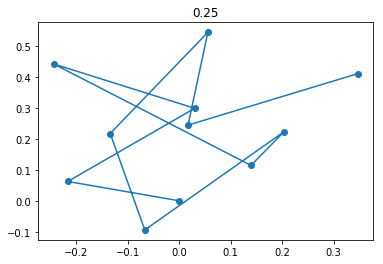

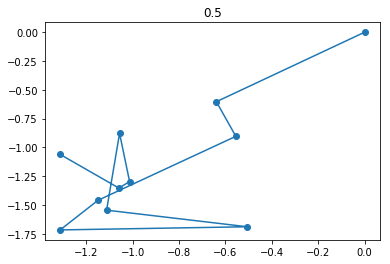

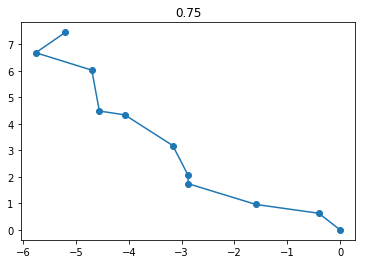

/home/bnapp/arivkindNet/imagewalker/fbm_mbm_lic/fbm.py:172: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  "Combination of increments n and Hurst value H "


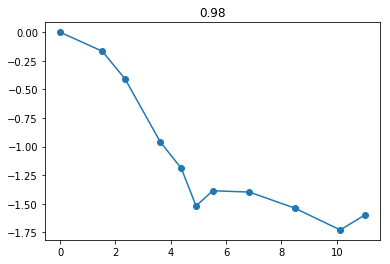

In [9]:
for h in [0.25, 0.5,0.75,0.98]:
# User input:
#     h = 0.4 # set 0.1<h<0.9 ; brownian motion: h=0.5 ; persistent motion: h>0.5 ; anti-persistent motion: h<0.5
    bm_steps = 64 # number of small brownian motion steps
    n_samples = 10 # number of samples from the brownian motion trajectory
    ocdr_period_sec=0.5 # ocular drift period [sec]
    fov_len_pix = 8 # fov_len_pix value corresponds with foveal pixl length and sets the motion max displacment to be +-(fov_len_pix/2)
    scale_sample_step = 1 # scales the brownian motion step size std

    # Generate 2D fractional brownian motion trajectory
    x , y = ocdr_fbm(bm_steps,h,ocdr_period_sec,n_samples,fov_len_pix,scale_sample_step)
    plt.figure()
    plt.plot(x,y,'-o') # uncomment to plot the trjectory
    plt.title(str(h))
    plt.show()


In [10]:
%timeit x , y = ocdr_fbm(bm_steps,h,ocdr_period_sec,n_samples,fov_len_pix,scale_sample_step)

7.8 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
30e-3*5e4

1500.0

In [12]:
7e-3*5e4

350.0

In [13]:
%timeit x , y = ocdr_fbm(bm_steps,h,ocdr_period_sec,5,fov_len_pix,scale_sample_step)

7.42 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit nana=np.sin(38)

880 ns ± 4.02 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
